Comparing BBI to other optimizers like Adam, Adagrad, SGD

In this notebook, we performed hyperparameter search and then trained and evaluated optimizers on MNIST dataset.

In [1]:
!pip install optuna
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import optuna
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from optuna.samplers import TPESampler
from optuna.pruners import BasePruner
# from inflation import BBI
from torch.optim import Adam, Adagrad, SGD
import seaborn as sns
import numpy as np
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.0 MB/s eta 0:00:00


In [2]:
from torch.optim.optimizer import Optimizer, required
import numpy as np
import torch
# from torchcontrib.optim import SWA
import math


class BBI(Optimizer):
    """Optimizer based on the BBI model of inflation.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        v0 (float): expected minimum of the potential (\Delta V in the paper)
        threshold0 (integer): threshold for fixed bounces (T_0 in the paper)
        threshold1 (integer): threshold for progress-dependent bounces (T_1 in the paper)
        deltaEn (float): extra initial energy (\delta E in the paper)
        consEn (bool): if True enforces energy conservation at every step
        n_fixed_bounces (integer): number of bounces every T_0 iterations (N_b in the paper)
    """
    def __init__(self, params, lr=required, eps1=1e-10, eps2 = 1e-40, v0=0, threshold0 = 1000, threshold = 3000, deltaEn = 0.0, consEn = True, n_fixed_bounces = 1, lr_grad = 0.001, beta1 = 0.9, beta2 = 0.999, adaptive = False):

            defaults = dict(lr=lr, eps1=eps1, eps2=eps2, v0=v0,
                            threshold = threshold, threshold0 = threshold0,
                            deltaEn = deltaEn, consEn = consEn,
                            n_fixed_bounces = n_fixed_bounces, lr_grad= lr_grad,
                            beta1 = beta1, beta2 = beta2
                            )
            self.energy = None
            self.adaptive = adaptive
            self.min_loss = None
            self.iteration = 0
            self.deltaEn = deltaEn
            self.n_fixed_bounces = n_fixed_bounces
            self.consEn = consEn
            super(BBI, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(BBI, self).__setstate__(state)

    def step(self, closure):

        loss = closure().item()

        # initialization
        if(self.iteration == 0):

            #define a random numbers generator, in order not to use the ambient seed and have random bounces even with the same ambient seed
            self.generator = torch.Generator(device = self.param_groups[0]["params"][0].device)
            self.generator.manual_seed(self.generator.seed()+1)

            #Initial energy
            self.initV = loss-self.param_groups[0]["v0"]
            self.init_energy = self.initV+self.deltaEn

            # Some counters
            self.counter0 = 0
            self.fixed_bounces_performed = 0
            self.counter = 0

            self.min_loss = float("inf")

        for group in self.param_groups:

            V = (loss - group["v0"])
            dt = group["lr"]
            eps1 = group["eps1"]
            eps2 = group["eps2"]
            threshold0 = group["threshold0"]
            threshold = group["threshold"]
            b1 = group["beta1"]
            b2 = group["beta2"]
            if V > eps2:

                EoverV = self.init_energy/V
                VoverE = V/self.init_energy

                # Now I check if loss and pi^2 are consistent with the initial value of the energy

                ps2_pre = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )

                for p in group["params"]:
                    param_state = self.state[p]
                    d_p = p.grad.data
                    #Initialize in the direction of the gradient, with magnitude related to deltaE
                    if "momentum_buffer" not in param_state:
                        buf = param_state["momentum_buffer"] = -(d_p/torch.norm(d_p))*torch.sqrt(torch.tensor( ((self.init_energy**2)/self.initV) - self.initV ))
                    else:
                        buf = param_state["momentum_buffer"]

                    # compute the current pi^2 . Pre means that this is the value before the iteration step
                    ps2_pre += torch.dot(buf.view(-1), buf.view(-1))


                if (self.consEn == True):

                    # Compare this \pi^2 with what it should have been if the energy was correct
                    ps2_correct = V*( (EoverV**2)-1.0 )

                    # Compute the rescaling factor, only if real
                    if torch.abs(ps2_pre-ps2_correct) <  eps1:
                        self.rescaling_pi = 1.0
                    elif ps2_correct < 0.0:
                        self.rescaling_pi = 1.0
                    else:
                        self.rescaling_pi = torch.sqrt(((ps2_correct/(ps2_pre))))


                # Perform the optimization step
                if (self.counter != threshold) and (self.counter0 != threshold0) :

                    for p in group["params"]:
                        if p.grad is None:
                            continue
                        d_p = p.grad.data
                        param_state = self.state[p]

                        if "momentum_buffer" not in param_state:
                            buf = param_state["momentum_buffer"] = torch.zeros_like(p.data)
                        else:
                            buf = param_state["momentum_buffer"]
                        if self.adaptive:
                          if "exp_avg" not in param_state:
                              param_state['exp_avg'] = torch.zeros_like(p.data)
                              param_state['exp_avg_sq'] = torch.zeros_like(p.data)
                          exp_avg, exp_avg_sq = param_state['exp_avg'], param_state['exp_avg_sq']
                          b1, b2 = 0.9, 0.999
                          exp_avg = torch.mul(exp_avg, b1) + (1 - b1)* d_p

                          exp_avg_sq = torch.mul(exp_avg_sq, b2) + (1-b2)*(d_p*d_p)

                          denom = exp_avg_sq.sqrt() + eps1

                          bias_correction1 = 1 / (1 - b1 ** (self.counter + 1))
                          bias_correction2 = 1 / (1 - b2 ** (self.counter + 1))

                          adapted_learning_rate = dt * bias_correction1 / math.sqrt(bias_correction2)

                          update = adapted_learning_rate * exp_avg / denom
                        else:
                          update = d_p
                        # Here the rescaling of momenta to enforce conservation of energy
                        if (self.consEn == True):
                            buf.mul_(self.rescaling_pi)

                        buf.add_(- 0.5 * dt * (VoverE + EoverV)*update)

                        p.data.add_(VoverE* dt* buf)

                    # Updates counters
                    self.counter0+=1
                    self.counter+=1
                    self.iteration+=1

                    # Checks progress
                    if V < self.min_loss:
                            self.min_loss = V
                            self.counter = 0
                # Bounces
                else:

                    #First we iterate once to compute pi^2, we randomly regenerate the directions, and we compute the new norm squared

                    ps20 = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )
                    ps2new = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )

                    for p in group["params"]:
                        param_state = self.state[p]

                        buf = param_state["momentum_buffer"]
                        ps20 += torch.dot(buf.view(-1), buf.view(-1))
                        new_buf = param_state["momentum_buffer"] = torch.rand(buf.size(), device=buf.device, generator = self.generator)-.5
                        ps2new += torch.dot(new_buf.view(-1), new_buf.view(-1))

                    # Then rescale them
                    for p in group["params"]:
                        param_state = self.state[p]
                        buf = param_state["momentum_buffer"]
                        buf.mul_(torch.sqrt(ps20/ps2new))

                    # Update counters
                    if (self.counter0 == threshold0):
                        self.fixed_bounces_performed+=1
                        if self.fixed_bounces_performed < self.n_fixed_bounces:
                            self.counter0 = 0
                        else:
                            self.counter0+=1
                    self.counter = 0
        return loss

In [3]:
# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist/', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 14616936.03it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3545607.90it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 147165412.53it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19146260.07it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [4]:
# Define simple CNN and loss function
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.fc1 = nn.Linear(32*7*7, 120)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


criterion = nn.CrossEntropyLoss()

In [9]:
# Function for tuning hyperparameters using optuna framework
def hyperparameter_search(trial: optuna.trial.Trial, optimizer, adaptive = False, wa = False):
    model = Net()
    if torch.cuda.is_available():
      model.cuda()
    learning_rates = trial.suggest_categorical("lr",np.logspace(-1, -5, num=30))
    batch_sizes = trial.suggest_categorical("bs",[32, 64, 128])
    if isinstance(optimizer(model.parameters(), lr=0.01), BBI):
        delta_E = trial.suggest_categorical("delta_e", np.linspace(0, 3, 30))
        if adaptive:
          learn_grad = trial.suggest_categorical("lr_grad", np.linspace(0.0001, 0.1, 30))
          beta1 = trial.suggest_categorical("beta1", np.linspace(0, 1, 30))
          beta2 = trial.suggest_categorical("beta2", np.linspace(0, 1, 30))
          optimizer = optimizer(model.parameters(), lr=learning_rates, deltaEn = delta_E, lr_grad = learn_grad  ,beta1 = beta1, beta2 = beta2, adaptive = True,)
        else:
            optimizer = optimizer(model.parameters(), lr=learning_rates, deltaEn = delta_E)
    elif isinstance(optimizer(model.parameters(), lr=0.01), SGD):
        momentum = trial.suggest_categorical("momentum", np.linspace(0.5, 0.999, 30))
        optimizer = optimizer(model.parameters(), lr=learning_rates, momentum = momentum)
    else:
        weight_decay_values = trial.suggest_categorical("wd", np.linspace(0, 0.5, 10))
        optimizer = optimizer(model.parameters(), lr=learning_rates, weight_decay=weight_decay_values)
    num_epochs = 3
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sizes, shuffle=True, num_workers=2)
    if wa:
      swa_model = AveragedModel(model)
      scheduler = CosineAnnealingLR(optimizer, T_max=100)
      swa_start = 2
      swa_scheduler = SWALR(optimizer, swa_lr=0.05)
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            if epoch > swa_start:
              swa_model.update_parameters(model)
            if isinstance(optimizer, BBI):
                def closure():
                    return loss
                optimizer.step(closure)
            else:
                optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [11]:
# Search for best parameters for Adam
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="adamm",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, Adam), n_trials=30)
print(study.best_params)

[I 2023-05-05 17:46:07,918] A new study created in RDB with name: adamm
[I 2023-05-05 17:46:38,545] Trial 0 finished with value: 10.28 and parameters: {'lr': 0.1, 'bs': 64, 'wd': 0.3333333333333333}. Best is trial 0 with value: 10.28.
[I 2023-05-05 17:47:04,983] Trial 1 finished with value: 9.58 and parameters: {'lr': 0.0727895384398315, 'bs': 128, 'wd': 0.16666666666666666}. Best is trial 0 with value: 10.28.
[I 2023-05-05 17:47:32,147] Trial 2 finished with value: 93.57 and parameters: {'lr': 0.0011721022975334804, 'bs': 128, 'wd': 0.1111111111111111}. Best is trial 2 with value: 93.57.
[I 2023-05-05 17:48:12,164] Trial 3 finished with value: 85.97 and parameters: {'lr': 2.592943797404667e-05, 'bs': 32, 'wd': 0.2777777777777778}. Best is trial 2 with value: 93.57.
[I 2023-05-05 17:48:38,733] Trial 4 finished with value: 74.7 and parameters: {'lr': 1.3738237958832637e-05, 'bs': 128, 'wd': 0.05555555555555555}. Best is trial 2 with value: 93.57.
[I 2023-05-05 17:49:09,994] Trial 5 fini

{'bs': 128, 'lr': 0.0016102620275609393, 'wd': 0.0}


In [12]:
# Search for best parameters for Adagrad
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="adagrad",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, Adagrad), n_trials=30)
print(study.best_params)

[I 2023-05-05 18:02:27,322] A new study created in RDB with name: adagrad
[I 2023-05-05 18:03:09,312] Trial 0 finished with value: 51.47 and parameters: {'lr': 6.723357536499335e-05, 'bs': 32, 'wd': 0.1111111111111111}. Best is trial 0 with value: 51.47.
[I 2023-05-05 18:03:51,100] Trial 1 finished with value: 89.06 and parameters: {'lr': 0.02807216203941177, 'bs': 32, 'wd': 0.2222222222222222}. Best is trial 1 with value: 89.06.
[I 2023-05-05 18:04:22,840] Trial 2 finished with value: 88.28 and parameters: {'lr': 0.0011721022975334804, 'bs': 64, 'wd': 0.16666666666666666}. Best is trial 1 with value: 89.06.
[I 2023-05-05 18:04:54,921] Trial 3 finished with value: 17.99 and parameters: {'lr': 3.5622478902624444e-05, 'bs': 64, 'wd': 0.5}. Best is trial 1 with value: 89.06.
[I 2023-05-05 18:05:21,816] Trial 4 finished with value: 83.44 and parameters: {'lr': 0.1, 'bs': 128, 'wd': 0.3333333333333333}. Best is trial 1 with value: 89.06.
[I 2023-05-05 18:06:04,091] Trial 5 finished with val

{'bs': 64, 'lr': 0.0030391953823131978, 'wd': 0.0}


In [13]:
# Search for best parameters for SGD
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="sgd",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, SGD), n_trials=30)
print(study.best_params)

[I 2023-05-05 18:18:00,167] A new study created in RDB with name: sgd
[I 2023-05-05 18:18:39,638] Trial 0 finished with value: 86.47 and parameters: {'lr': 0.0002395026619987486, 'bs': 32, 'momentum': 0.5516206896551724}. Best is trial 0 with value: 86.47.
[I 2023-05-05 18:19:06,163] Trial 1 finished with value: 83.42 and parameters: {'lr': 0.00045203536563602454, 'bs': 128, 'momentum': 0.6548620689655172}. Best is trial 0 with value: 86.47.
[I 2023-05-05 18:19:32,902] Trial 2 finished with value: 98.27 and parameters: {'lr': 0.020433597178569417, 'bs': 128, 'momentum': 0.7064827586206897}. Best is trial 2 with value: 98.27.
[I 2023-05-05 18:19:59,178] Trial 3 finished with value: 8.04 and parameters: {'lr': 1e-05, 'bs': 128, 'momentum': 0.7581034482758621}. Best is trial 2 with value: 98.27.
[I 2023-05-05 18:20:29,721] Trial 4 finished with value: 88.37 and parameters: {'lr': 0.00017433288221999874, 'bs': 64, 'momentum': 0.878551724137931}. Best is trial 2 with value: 98.27.
[I 2023-0

{'bs': 32, 'lr': 0.0041753189365604, 'momentum': 0.9817931034482759}


In [14]:
# Search for best parameters for BBI
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="bbi",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, BBI), n_trials=30)
print(study.best_params)

[I 2023-05-05 18:33:23,575] A new study created in RDB with name: bbi
[I 2023-05-05 18:33:56,695] Trial 0 finished with value: 98.82 and parameters: {'lr': 0.1, 'bs': 64, 'delta_e': 2.0689655172413794}. Best is trial 0 with value: 98.82.
[I 2023-05-05 18:34:25,089] Trial 1 finished with value: 9.88 and parameters: {'lr': 0.0001268961003167922, 'bs': 128, 'delta_e': 1.4482758620689655}. Best is trial 0 with value: 98.82.
[I 2023-05-05 18:35:08,513] Trial 2 finished with value: 74.09 and parameters: {'lr': 0.0006210169418915617, 'bs': 32, 'delta_e': 2.896551724137931}. Best is trial 0 with value: 98.82.
[I 2023-05-05 18:35:41,840] Trial 3 finished with value: 9.8 and parameters: {'lr': 0.0002395026619987486, 'bs': 64, 'delta_e': 2.793103448275862}. Best is trial 0 with value: 98.82.
[I 2023-05-05 18:36:25,925] Trial 4 finished with value: 16.53 and parameters: {'lr': 9.236708571873866e-05, 'bs': 32, 'delta_e': 2.4827586206896552}. Best is trial 0 with value: 98.82.
[I 2023-05-05 18:36:54

{'bs': 64, 'delta_e': 2.0689655172413794, 'lr': 0.1}


In [15]:
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="bbi_adap",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, BBI, adaptive = True), n_trials=30)
print(study.best_params)

[I 2023-05-05 18:50:51,360] A new study created in RDB with name: bbi_adap
[I 2023-05-05 18:51:39,616] Trial 0 finished with value: 70.59 and parameters: {'lr': 0.0030391953823131978, 'bs': 32, 'delta_e': 1.5517241379310345, 'lr_grad': 0.0035448275862068964, 'beta1': 0.7931034482758621, 'beta2': 0.6206896551724138}. Best is trial 0 with value: 70.59.
[I 2023-05-05 18:52:09,679] Trial 1 finished with value: 93.73 and parameters: {'lr': 0.014873521072935119, 'bs': 128, 'delta_e': 1.4482758620689655, 'lr_grad': 0.05866206896551725, 'beta1': 0.24137931034482757, 'beta2': 0.9655172413793103}. Best is trial 1 with value: 93.73.
[I 2023-05-05 18:52:39,059] Trial 2 finished with value: 97.9 and parameters: {'lr': 0.0727895384398315, 'bs': 128, 'delta_e': 1.7586206896551724, 'lr_grad': 0.024213793103448275, 'beta1': 0.7241379310344828, 'beta2': 0.7241379310344828}. Best is trial 2 with value: 97.9.
[I 2023-05-05 18:53:08,885] Trial 3 finished with value: 61.32 and parameters: {'lr': 0.005736152

{'beta1': 0.10344827586206896, 'beta2': 0.1724137931034483, 'bs': 128, 'delta_e': 0.7241379310344828, 'lr': 0.1, 'lr_grad': 0.05177241379310345}


In [13]:
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="bbi_wa_",
    storage="sqlite:///optuna1.db",
)
study.optimize(lambda trial: hyperparameter_search(trial, BBI, wa = True), n_trials=30)
print(study.best_params)

[I 2023-05-06 17:22:07,984] A new study created in RDB with name: bbi_wa_
[I 2023-05-06 17:22:52,667] Trial 0 finished with value: 12.86 and parameters: {'lr': 0.0002395026619987486, 'bs': 32, 'delta_e': 0.0}. Best is trial 0 with value: 12.86.
[I 2023-05-06 17:23:20,809] Trial 1 finished with value: 97.97 and parameters: {'lr': 0.03856620421163472, 'bs': 128, 'delta_e': 0.8275862068965517}. Best is trial 1 with value: 97.97.
[I 2023-05-06 17:23:54,441] Trial 2 finished with value: 10.11 and parameters: {'lr': 0.00032903445623126676, 'bs': 64, 'delta_e': 0.7241379310344828}. Best is trial 1 with value: 97.97.
[I 2023-05-06 17:24:22,354] Trial 3 finished with value: 93.37 and parameters: {'lr': 0.010826367338740546, 'bs': 128, 'delta_e': 2.896551724137931}. Best is trial 1 with value: 97.97.
[I 2023-05-06 17:25:06,472] Trial 4 finished with value: 97.69 and parameters: {'lr': 0.005736152510448681, 'bs': 32, 'delta_e': 0.7241379310344828}. Best is trial 1 with value: 97.97.
[I 2023-05-06

{'bs': 64, 'delta_e': 1.6551724137931034, 'lr': 0.0727895384398315}


In [14]:
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="bbi_wa_adapt_",
    storage="sqlite:///optuna1.db",
)
study.optimize(lambda trial: hyperparameter_search(trial, BBI, wa = True, adaptive=True), n_trials=30)
print(study.best_params)

[I 2023-05-06 17:46:42,371] A new study created in RDB with name: bbi_wa_adapt_
[I 2023-05-06 17:47:31,334] Trial 0 finished with value: 97.34 and parameters: {'lr': 0.1, 'bs': 32, 'delta_e': 0.20689655172413793, 'lr_grad': 0.07244137931034483, 'beta1': 0.10344827586206896, 'beta2': 0.41379310344827586}. Best is trial 0 with value: 97.34.
[I 2023-05-06 17:48:00,658] Trial 1 finished with value: 8.91 and parameters: {'lr': 4.893900918477499e-05, 'bs': 128, 'delta_e': 1.5517241379310345, 'lr_grad': 0.07588620689655172, 'beta1': 0.27586206896551724, 'beta2': 0.8275862068965517}. Best is trial 0 with value: 97.34.
[I 2023-05-06 17:48:36,179] Trial 2 finished with value: 11.85 and parameters: {'lr': 0.0016102620275609393, 'bs': 64, 'delta_e': 1.6551724137931034, 'lr_grad': 0.03454827586206897, 'beta1': 0.034482758620689655, 'beta2': 0.24137931034482757}. Best is trial 0 with value: 97.34.
[I 2023-05-06 17:49:06,089] Trial 3 finished with value: 15.63 and parameters: {'lr': 6.723357536499335

{'beta1': 0.10344827586206896, 'beta2': 0.41379310344827586, 'bs': 32, 'delta_e': 0.20689655172413793, 'lr': 0.1, 'lr_grad': 0.07244137931034483}


In [27]:
# Function for testing optimizers, which return train, test loss per epoch and final accuracy
def test(model, optimizer, batch_sizes, wa = False):
    num_epochs = 5
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sizes, shuffle=True, num_workers=2)
    train_losses = []
    test_losses = []
    if wa:
      swa_model = AveragedModel(model)
      scheduler = CosineAnnealingLR(optimizer, T_max=100)
      swa_start = 3
      swa_scheduler = SWALR(optimizer, swa_lr=0.05)
    for epoch in range(num_epochs):
        loss_epoch = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_epoch += loss.item()
            loss.backward()
            if wa:
              if epoch > swa_start:
                swa_model.update_parameters(model)
            if isinstance(optimizer, BBI):
                def closure():
                    return loss
                optimizer.step(closure)
            else:
                optimizer.step()
        train_losses.append(loss_epoch/len(train_loader))
        loss_epoch = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_epoch+= float(loss.item())
        test_losses.append(loss_epoch/len(test_loader))

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct/total
    # accuracy = 1
    return train_losses, test_losses, accuracy

In [28]:
# Testing Adam
model = Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = Adam(model.parameters(), lr = 0.001)
trainloss_adam, testloss_adam, accuracy = test(model, optimizer, 128)
print("Test Accuracy of Adam", accuracy)

Test Accuracy of Adam 0.9895


In [29]:
# Testing Adagrad
model = Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = Adagrad(model.parameters(), lr = 0.003)
trainloss_adagrad, testloss_adagrad, accuracy  = test(model, optimizer, 64)
print("Test Accuracy of Adagrad", accuracy)

Test Accuracy of Adagrad 0.969


In [30]:
#Testing SGD
model = Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = SGD(model.parameters(), lr = 0.004, momentum=0.98)
trainloss_sgd, testloss_sgd, accuracy = test(model, optimizer, 32)
print("Test Accuracy of SGD", accuracy)

Test Accuracy of SGD 0.9863


In [31]:
#Testing BBI
model = Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = BBI(model.parameters(), lr =  0.1, deltaEn=2.06)
trainloss_bbi, testloss_bbi, accuracy= test(model, optimizer, 64)
print("Test Accuracy of BBI", accuracy)

Test Accuracy of BBI 0.9876


In [32]:
model = Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = BBI(model.parameters(), lr =  0.1, deltaEn=0.72, adaptive = True, 
                lr_grad=0.05, beta1 = 0.1, beta2 = 0.17, )
trainloss_bbi_a, testloss_bbi_a, accuracy= test(model, optimizer, 128)
print("Test Accuracy of BBI adaptive", accuracy)

Test Accuracy of BBI adaptive 0.982


In [20]:
model = Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = BBI(model.parameters(), lr =  0.07, deltaEn=1.65)
trainloss_bbi_wa, testloss_bbi_wa, accuracy= test(model, optimizer, 64,  wa = True)
print("Test Accuracy of BBI with weight averaging", accuracy)

Test Accuracy of BBI with weight averaging 0.988


In [21]:
model = Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = BBI(model.parameters(), lr =  0.1, deltaEn=0.2, adaptive = True, 
                lr_grad=0.07, beta1 = 0.1, beta2 = 0.4, )
trainloss_bbi_a_wa, testloss_bbi_a_wa, accuracy= test(model, optimizer, 32, wa = True)
print("Test Accuracy of BBI with weight averaging and adaptive stepsize", accuracy)

Test Accuracy of BBI with weight averaging and adaptive stepsize 0.9591


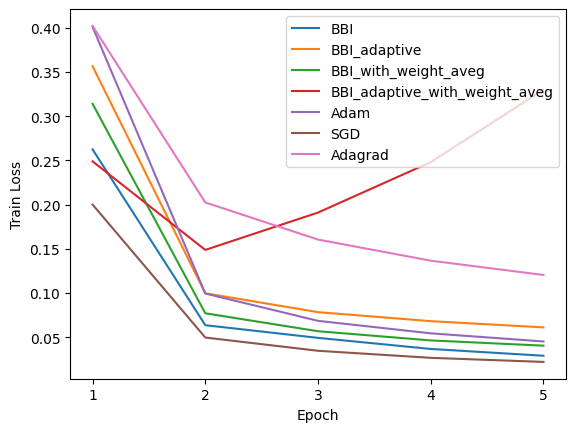

In [35]:
#PLot train loss

t = np.arange(1, 6)

g = sns.lineplot(y=trainloss_bbi, x=t, label='BBI')
sns.lineplot(y=trainloss_bbi_a, x=t, label='BBI_adaptive')
sns.lineplot(y=trainloss_bbi_wa, x=t, label='BBI_with_weight_aveg')
sns.lineplot(y=trainloss_bbi_a_wa, x=t, label='BBI_adaptive_with_weight_aveg')
sns.lineplot(y=trainloss_adam, x=t, label='Adam')
sns.lineplot(y=trainloss_sgd, x=t, label='SGD')
sns.lineplot(y=trainloss_adagrad, x=t, label='Adagrad')
g.set(xticks=list(range(1,6)))
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

plt.legend()
plt.show()

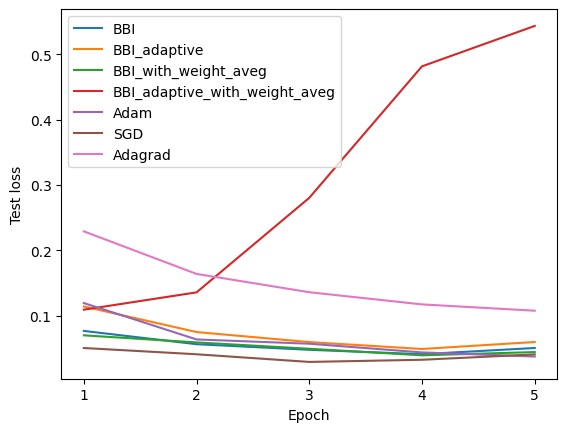

In [36]:
# Plot test loss
t = np.arange(1, 6, 1)

g = sns.lineplot(y=testloss_bbi, x=t, label='BBI')
sns.lineplot(y=testloss_bbi_a, x=t, label='BBI_adaptive')
sns.lineplot(y=testloss_bbi_wa, x=t, label='BBI_with_weight_aveg')
sns.lineplot(y=testloss_bbi_a_wa, x=t, label='BBI_adaptive_with_weight_aveg')
sns.lineplot(y=testloss_adam, x=t, label='Adam')
sns.lineplot(y=testloss_sgd, x=t, label='SGD')
sns.lineplot(y=testloss_adagrad, x=t, label='Adagrad')
g.set(xticks=list(range(1,6)))
# plt.title('Three Lines Plot')
plt.xlabel('Epoch')
plt.ylabel('Test loss')

plt.legend()
plt.show()

Looking at plots above, we can make several conclusions:
1) The performance of BBI is not far away from other famous optimizers, however both on train and test set it is a little worse than others.
2) Looking at the test plot, we observe that BBI can be not monotone, similar to SGD. We can assume that it's the property of the method, or it stated to overfit at epoch 4.